## Import and process data

In [5]:
## Import required packages
import pandas as pd
import geopandas as gpd
import folium
from folium import plugins
import branca
import time
start_time = time.time()

property data: https://public.opendatasoft.com/explore/dataset/zillow-neighborhoods/table/?q=DC&location=11,38.89845,-77.01458&basemap=jawg.streets&dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6InppbGxvdy1uZWlnaGJvcmhvb2RzIiwib3B0aW9ucyI6eyJxIjoiREMifX0sImNoYXJ0cyI6W3siYWxpZ25Nb250aCI6dHJ1ZSwidHlwZSI6ImNvbHVtbiIsImZ1bmMiOiJDT1VOVCIsInNjaWVudGlmaWNEaXNwbGF5Ijp0cnVlLCJjb2xvciI6IiNGRjUxNUEifV0sInhBeGlzIjoic3RhdGUiLCJtYXhwb2ludHMiOjUwLCJzb3J0IjoiIn1dLCJ0aW1lc2NhbGUiOiIiLCJkaXNwbGF5TGVnZW5kIjp0cnVlLCJhbGlnbk1vbnRoIjp0cnVlfQ%3D%3D

In [8]:
## Load geojson as geopandas dataframe
dc_zil_gdf = gpd.read_file("dc_research/zillow-neighborhoods.geojson")    
dc_zil_gdf.head()

,city,name,regionid,county,state,geometry
0,Washington,West End,121808,District of Columbia,DC,"POLYGON ((-77.04999 38.90961, -77.04997 38.909..."
1,Washington,Skyland,403499,District of Columbia,DC,"POLYGON ((-76.96974 38.85723, -76.97005 38.857..."
2,Washington,Brookland,121681,District of Columbia,DC,"POLYGON ((-76.98386 38.94247, -76.98344 38.942..."
3,Washington,Capitol View,121686,District of Columbia,DC,"POLYGON ((-76.91857 38.88571, -76.91857 38.885..."
4,Washington,Observatory Circle,268821,District of Columbia,DC,"POLYGON ((-77.06667 38.92432, -77.06637 38.924..."


In [11]:
dc_zil_gdf.columns

Index(['city', 'name', 'regionid', 'county', 'state', 'geometry'], dtype='object')

In [12]:
dc_zil_gdf.shape

(137, 6)

Load crime data in DC

In [26]:
dc_crime_2019 = pd.read_csv('dc_research/Crime_Incidents_in_2019.csv')

In [27]:
dc_crime_2019.columns

Index(['X', 'Y', 'CCN', 'REPORT_DAT', 'SHIFT', 'METHOD', 'OFFENSE', 'BLOCK',
       'XBLOCK', 'YBLOCK', 'WARD', 'ANC', 'DISTRICT', 'PSA',
       'NEIGHBORHOOD_CLUSTER', 'BLOCK_GROUP', 'CENSUS_TRACT',
       'VOTING_PRECINCT', 'LATITUDE', 'LONGITUDE', 'BID', 'START_DATE',
       'END_DATE', 'OBJECTID', 'OCTO_RECORD_ID'],
      dtype='object')

In [28]:
dc_crime_2019.shape

(33910, 25)

In [29]:
dc_crime_2019.head()

,X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID
0,-76.982944,38.887599,10199597,2019-11-07T11:41:36.000Z,DAY,OTHERS,THEFT/OTHER,1500 - 1599 BLOCK OF INDEPENDENCE AVENUE SE,401480.0,135528.0,...,006801 2,6801.0,Precinct 87,38.887592,-76.982941,NaN,2019-11-07T10:36:52.000Z,2019-11-07T11:42:02.000Z,429611163,10199597-01
1,-77.010378,38.820469,17084415,2019-01-28T00:00:00.000Z,MIDNIGHT,GUN,HOMICIDE,130 - 199 BLOCK OF IRVINGTON STREET SW,399099.0,128076.0,...,010900 2,10900.0,Precinct 126,38.820461,-77.010375,NaN,2017-05-19T22:58:53.000Z,2017-05-20T02:26:45.000Z,429841378,17084415-01
2,-76.952665,38.920544,18208996,2019-03-22T16:18:15.000Z,EVENING,OTHERS,THEFT/OTHER,2400 BLOCK OF MARKET STREET NE,404105.0,139186.0,...,009000 1,9000.0,Precinct 139,38.920536,-76.952663,NaN,2018-12-09T17:01:49.000Z,2018-12-09T18:49:21.000Z,429890611,18208996-01
3,-77.027565,38.897353,18221681,2019-01-01T10:24:06.000Z,DAY,OTHERS,THEFT/OTHER,1100 - 1199 BLOCK OF F STREET NW,397609.0,136611.0,...,005800 1,5800.0,Precinct 129,38.897346,-77.027563,DOWNTOWN,2018-12-31T11:49:19.000Z,2018-12-31T14:43:21.000Z,429890721,18221681-01
4,-77.021929,38.899129,18221708,2019-01-01T15:48:01.000Z,EVENING,OTHERS,THEFT/OTHER,700 - 799 BLOCK OF 7TH STREET NW,398098.0,136808.0,...,005800 1,5800.0,Precinct 129,38.899121,-77.021926,DOWNTOWN,2018-12-31T12:48:46.000Z,2018-12-31T12:51:47.000Z,429890728,18221708-01


In [30]:
import pyproj
from shapely.geometry import shape, Point
from shapely.ops import transform
from functools import partial

In [31]:
## Enigneer neighborhood name into crime dataset based on longitude and latitude

dc_crime_2019['neighborhood'] = ""
long = dc_crime_2019.columns.get_loc('LONGITUDE')
lat = dc_crime_2019.columns.get_loc('LATITUDE')
geometry = dc_zil_gdf.columns.get_loc('geometry')
name = dc_zil_gdf.columns.get_loc('name')

## use shapely to check if lat/lon is within the zillow neighborhood shape
for i in range(len(dc_crime_2019)):
    point = Point(dc_crime_2019.iloc[i,long],dc_crime_2019.iloc[i,lat]) ## Longitude, Latitude

    for j in range(len(dc_zil_gdf)):
        polygon = shape(dc_zil_gdf.iloc[j,geometry])
        if polygon.contains(point):
            dc_crime_2019.iloc[i, dc_crime_2019.columns.get_loc('neighborhood')] = dc_zil_gdf.iloc[j,name]
            
dc_crime_2019.to_csv("dc_crime_2019_final.csv", index = False)  
        
dc_crime_2019.head()

,X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,BID,START_DATE,END_DATE,OBJECTID,OCTO_RECORD_ID,neighborhood
0,-76.982944,38.887599,10199597,2019-11-07T11:41:36.000Z,DAY,OTHERS,THEFT/OTHER,1500 - 1599 BLOCK OF INDEPENDENCE AVENUE SE,401480.0,135528.0,...,6801.0,Precinct 87,38.887592,-76.982941,NaN,2019-11-07T10:36:52.000Z,2019-11-07T11:42:02.000Z,429611163,10199597-01,Kingman Park
1,-77.010378,38.820469,17084415,2019-01-28T00:00:00.000Z,MIDNIGHT,GUN,HOMICIDE,130 - 199 BLOCK OF IRVINGTON STREET SW,399099.0,128076.0,...,10900.0,Precinct 126,38.820461,-77.010375,NaN,2017-05-19T22:58:53.000Z,2017-05-20T02:26:45.000Z,429841378,17084415-01,Bellevue
2,-76.952665,38.920544,18208996,2019-03-22T16:18:15.000Z,EVENING,OTHERS,THEFT/OTHER,2400 BLOCK OF MARKET STREET NE,404105.0,139186.0,...,9000.0,Precinct 139,38.920536,-76.952663,NaN,2018-12-09T17:01:49.000Z,2018-12-09T18:49:21.000Z,429890611,18208996-01,Fort Lincoln
3,-77.027565,38.897353,18221681,2019-01-01T10:24:06.000Z,DAY,OTHERS,THEFT/OTHER,1100 - 1199 BLOCK OF F STREET NW,397609.0,136611.0,...,5800.0,Precinct 129,38.897346,-77.027563,DOWNTOWN,2018-12-31T11:49:19.000Z,2018-12-31T14:43:21.000Z,429890721,18221681-01,Penn Quarter
4,-77.021929,38.899129,18221708,2019-01-01T15:48:01.000Z,EVENING,OTHERS,THEFT/OTHER,700 - 799 BLOCK OF 7TH STREET NW,398098.0,136808.0,...,5800.0,Precinct 129,38.899121,-77.021926,DOWNTOWN,2018-12-31T12:48:46.000Z,2018-12-31T12:51:47.000Z,429890728,18221708-01,Chinatown


In [33]:
dc_crime_2019['METHOD'].value_counts()

OTHERS    31621
GUN        1616
KNIFE       673
Name: METHOD, dtype: int64

In [34]:
dc_crime_2019['OFFENSE'].value_counts()

THEFT/OTHER                   15548
THEFT F/AUTO                  10711
ROBBERY                        2236
MOTOR VEHICLE THEFT            2207
ASSAULT W/DANGEROUS WEAPON     1568
BURGLARY                       1272
SEX ABUSE                       195
HOMICIDE                        165
ARSON                             8
Name: OFFENSE, dtype: int64

The cost of crime, data source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2835847/

In [37]:
## Create cost of different type crime table

d = {'OFFENSE':['THEFT/OTHER','THEFT F/AUTO','ROBBERY','MOTOR VEHICLE THEFT',
               'ASSAULT W/DANGEROUS WEAPON','BURGLARY','SEX ABUSE','HOMICIDE','ARSON'],
    'COST_of_crime_$':[3532,5000,42310,10772,
                    107020,14096,240776,8982907,21103]}

In [38]:
crime_cost = pd.DataFrame(d)
crime_cost

,OFFENSE,COST_of_crime_$
0,THEFT/OTHER,3532
1,THEFT F/AUTO,5000
2,ROBBERY,42310
3,MOTOR VEHICLE THEFT,10772
4,ASSAULT W/DANGEROUS WEAPON,107020
5,BURGLARY,14096
6,SEX ABUSE,240776
7,HOMICIDE,8982907
8,ARSON,21103


In [43]:
dc_crime_2019 = pd.merge(dc_crime_2019, crime_cost, how='left', on='OFFENSE')

In [64]:
nhood_crimecost = dc_crime_2019.groupby('neighborhood').agg(
                                                        crime_cost = ('COST_of_crime_$',sum),
                                                        crime_count = ('COST_of_crime_$','count'))

In [65]:
nhood_crimecost

,crime_cost,crime_count
neighborhood,,
,1835494,60
Adams Morgan,15662896,634
American University Park,12278163,426
Anacostia,31751566,250
Anacostia Naval Station - Boiling Air Force Base,110552,2
...,...,...
West End,1369228,190
Woodland-Normanstone Terrace,288092,7
Woodlands,10543049,41


In [66]:
nhood_map = dc_zil_gdf.merge(nhood_crimecost, left_on = 'name',right_index = True)
nhood_map.head()

,city,name,regionid,county,state,geometry,crime_cost,crime_count
0,Washington,West End,121808,District of Columbia,DC,"POLYGON ((-77.04999 38.90961, -77.04997 38.909...",1369228,190
1,Washington,Skyland,403499,District of Columbia,DC,"POLYGON ((-76.96974 38.85723, -76.97005 38.857...",10352385,53
2,Washington,Brookland,121681,District of Columbia,DC,"POLYGON ((-76.98386 38.94247, -76.98344 38.942...",32722275,621
3,Washington,Capitol View,121686,District of Columbia,DC,"POLYGON ((-76.91857 38.88571, -76.91857 38.885...",1149782,63
4,Washington,Observatory Circle,268821,District of Columbia,DC,"POLYGON ((-77.06667 38.92432, -77.06637 38.924...",51932,8


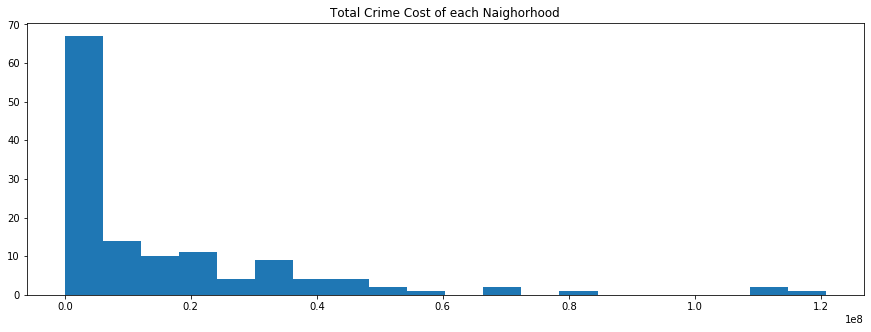

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.hist(nhood_map['crime_cost'], bins=20)
plt.title('Total Crime Cost of each Naighorhood')
plt.show()

In [59]:
nhood_map['crime_cost'].max()

120792200

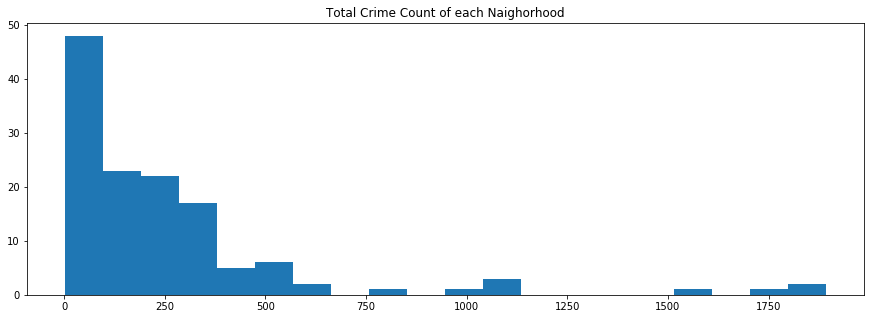

In [69]:
plt.figure(figsize=(15,5))
plt.hist(nhood_map['crime_count'], bins=20)
plt.title('Total Crime Count of each Naighorhood')
plt.show()

In [70]:
nhood_map['crime_count'].max()

1892

## Crime map based on cost of crime incidents

In [79]:
nhood_map['QP_cost'] = nhood_map['crime_cost'] / nhood_map['crime_cost'].sum()
nhood_map['QPcost_str'] = nhood_map['QP_cost'].apply(lambda x : str(round(x*100, 1)) + '%')

nhood_map['QP_count'] = nhood_map['crime_count'] / nhood_map['crime_count'].sum()
nhood_map['QPcount_str'] = nhood_map['QP_count'].apply(lambda x : str(round(x*100, 1)) + '%')

In [128]:
name = "DC Crime Map"
leg_brks = [0, 1000000, 3000000, 6000000, 10000000, 15000000, 25000000,40000000, 60000000, 120792200]
colors = ['#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026']
#colorscale = branca.colormap.linear.YlOrRd_09.scale(nhood_map['crime_cost'].min(), nhood_map['crime_cost'].max()) 
colorscale = branca.colormap.StepColormap(colors = colors,
                                           index = leg_brks,
                                            vmin=nhood_map['crime_cost'].min(),
                                            vmax=nhood_map['crime_cost'].max())
                                          
#colorscale = colorscale.to_step(index = leg_brks) ## sets quantile breaks 
colorscale.caption = name ## adds name for legend
colorscale

In [105]:
dc_zil_gdf[dc_zil_gdf['name'] == 'Brightwood']['geometry'].centroid

/Users/jingsixu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


12    POINT (-77.03782 38.96552)
dtype: geometry

In [122]:
## identifies the center point of all the neighborhood shapes 
centroid=dc_zil_gdf.geometry.centroid 
## initiaes a map based on the centroid
cost=folium.Map(location=[centroid.y.mean(), centroid.x.mean()], tiles="Stamen Toner", zoom_start=12) 

style_function = lambda x: {"weight":1
                             , 'color': '#545453'
                             ## if variable is 0 map is a very light grey
                             ## else colorscale applies based on variable
                             , 'fillColor':'#9B9B9B' if x['properties']['crime_cost'] == 0 
                             else colorscale(x['properties']['crime_cost'])
                             ## similarly opacity is increased if value is 0
                             , 'fillOpacity': 0.2 if x['properties']['crime_cost'] == 0 
                             else 0.7}

folium.GeoJson(
    nhood_map,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['name', 'crime_cost','QPcost_str','crime_count', 'QPcount_str'],
        aliases=['Neighbourhood', 'Incidents cost','Percent of total cost','Incidents amount', 'Percent of total amount'],
        localize=True
    )
).add_to(cost)

folium.Circle(
    radius=200,
    location=[-77.03782, 38.96552],
    popup='The Waterfront',
    color='crimson',
    fill=False,
).add_to(cost)


colorscale.add_to(cost)
colorscale.caption = 'DC Crime Map 2019 - cost of crime'
cost

In [123]:
cost.save('DC_Crime_Cost_Map_2019.html')

## Crime map based on amount of crime incidents

In [129]:
name = "DC Crime Map"
leg_brks2 = [0, 50.0, 150.0, 250.0, 350.0, 500, 750.0, 1000.0, 1400.0, 1892.0]
colors2 = ['#f7fcf0','#e0f3db','#ccebc5','#a8ddb5','#7bccc4','#4eb3d3','#2b8cbe','#0868ac','#084081']
colorscale2 = branca.colormap.StepColormap(colors = colors2,
                                           index = leg_brks2,
                                            vmin=nhood_map['crime_count'].min(),
                                            vmax=nhood_map['crime_count'].max()) 
colorscale2.caption = name ## adds name for legend
colorscale2

In [131]:
## initiaes a map based on the centroid
count=folium.Map(location=[centroid.y.mean(), centroid.x.mean()], tiles="Stamen Toner", zoom_start=12) 

style_function2 = lambda x: {"weight":1
                             , 'color': '#545453'
                             ## if variable is 0 map is a very light grey
                             ## else colorscale applies based on variable
                             , 'fillColor':'#9B9B9B' if x['properties']['crime_count'] == 0 
                             else colorscale2(x['properties']['crime_count'])
                             ## similarly opacity is increased if value is 0
                             , 'fillOpacity': 0.2 if x['properties']['crime_count'] == 0 
                             else 0.7}

folium.GeoJson(
    nhood_map,
    style_function=style_function2,
    tooltip=folium.GeoJsonTooltip(
        fields=['name', 'crime_cost','QPcost_str','crime_count', 'QPcount_str'],
        aliases=['Neighbourhood', 'Incidents cost','Percent of total cost','Incidents amount', 'Percent of total amount'],
        localize=True
    )
).add_to(count)

folium.Circle(
    radius=200,
    location=[-77.03782, 38.96552],
    popup='The Waterfront',
    color='crimson',
    fill=False,
).add_to(count)


colorscale2.add_to(count)
colorscale2.caption = 'DC Crime Map 2019 - Amount of crime'
count

In [132]:
count.save('DC_Crime_Count_Map_2019.html') 

## Cost of crime incident over last three years (2017, 2018, 2019)

In [134]:
## get data of last three years
df_list = []
for i in [2017, 2018, 2019]:
    df = pd.read_csv('dc_research/Crime_Incidents_in_'+str(i)+'.csv')
    df['year'] = i
    df_list.append(df)
    
df_all = pd.concat(df_list)
del df_list

In [135]:
df_all['year'].value_counts()

2019    33910
2018    33753
2017    33091
Name: year, dtype: int64

In [136]:
## add neighborhood name 

df_all['neighborhood'] = ""
long = df_all.columns.get_loc('LONGITUDE')
lat = df_all.columns.get_loc('LATITUDE')
geometry = dc_zil_gdf.columns.get_loc('geometry')
name = dc_zil_gdf.columns.get_loc('name')

## use shapely to check if lat/lon is within the zillow neighborhood shape
for i in range(len(df_all)):
    point = Point(df_all.iloc[i,long],df_all.iloc[i,lat]) ## Longitude, Latitude

    for j in range(len(dc_zil_gdf)):
        polygon = shape(dc_zil_gdf.iloc[j,geometry])
        if polygon.contains(point):
            df_all.iloc[i, df_all.columns.get_loc('neighborhood')] = dc_zil_gdf.iloc[j,name]

In [137]:
## merge with crime cost
df_all = pd.merge(df_all, crime_cost, how='left', on='OFFENSE')

In [139]:
## get brightwood
df_brightwood = df_all[df_all['neighborhood'] == 'Brightwood']

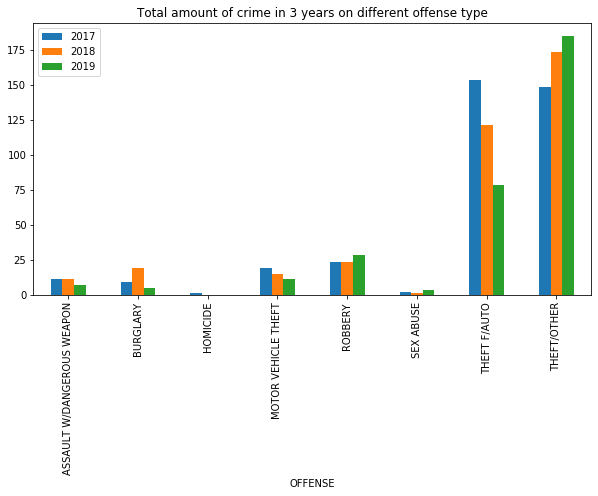

In [247]:
df_brightwood.groupby(['OFFENSE','year']).agg(crime_amount = ('COST_of_crime_$','count'))['crime_amount'].unstack().plot(kind = 'bar', figsize = (10,5))
#plt.ylim(0,1500000)
plt.xlabel('OFFENSE')
plt.title('Total amount of crime in 3 years on different offense type')
plt.legend()

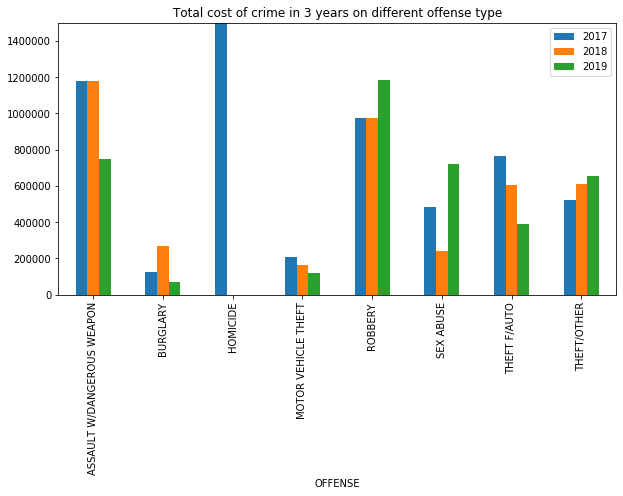

In [240]:
df_brightwood.groupby(['OFFENSE','year']).agg(crime_cost = ('COST_of_crime_$',sum))['crime_cost'].unstack().plot(kind = 'bar', figsize = (10,5))
plt.ylim(0,1500000)
plt.xlabel('OFFENSE')
plt.title('Total cost of crime in 3 years on different offense type')
plt.legend()
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=3)


Text(0.5, 1.0, 'Total cost of crime in 3 years')

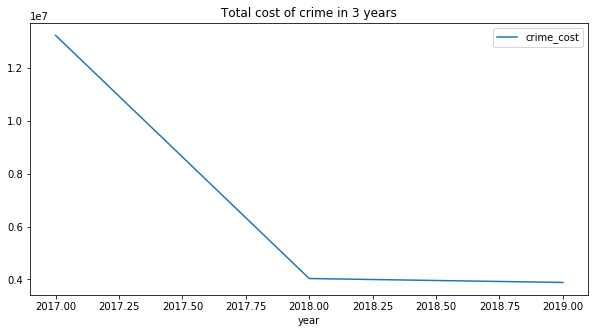

In [204]:
df_brightwood.groupby(['year']).agg(crime_cost = ('COST_of_crime_$',sum)).plot(figsize = (10,5))
plt.xlabel('year')
plt.title('Total cost of crime in 3 years')

The total cost of crime declined drameticaly from year 2017 to year 2018. The cost of assault with weapon, theft for auto goes down very quick in three years while the cost of robbery and sex abuse went up. 

## Visualize location of crime incident happened in Brightwood (2019)

#### 3D map (Plotly)

In [160]:
Neighborhood = 'Brightwood'

loc_bw = dc_crime_2019[dc_crime_2019['neighborhood'] == Neighborhood]
ave_lat = sum(loc_bw.Y)/len(loc_bw.Y)
ave_long = sum(loc_bw.X)/len(loc_bw.X)


In [188]:
import plotly
import plotly.graph_objs as go
from plotly.tools import make_subplots

# Generate an access token for this project 
mapbox_access_token = 'pk.eyJ1IjoieHVqaW5nc2kiLCJhIjoiY2tjaWYwOHhyMTV5bDMybzMxZXM3bTM2ZCJ9.84qzc_7V9EMud5OHvrbuHg'
#my_style = "mapbox://styles/xujingsi/ckciibwkq1sip1iqm6v1p1vvt"
my_style = 'mapbox://styles/xujingsi/ckcikjmd72mtq1jmgfc1e5pht'

c = { "THEFT/OTHER": "green", "THEFT F/AUTO": "gray",
      "MOTOR VEHICLE THEFT": "gold", "BURGLARY": "orange",
      "ARSON": "royalblue", "ROBBERY": "purple",
      "ASSAULT W/DANGEROUS WEAPON": "brown", "SEX ABUSE": "darkred",
      "HOMICIDE": "red"}

trace = []
for offense, color in c.items():
    trace.append(go.Scattermapbox(
        lat = loc_bw[loc_bw['OFFENSE']==offense]['Y'],
        lon = loc_bw[loc_bw['OFFENSE']==offense]['X'],
        marker = go.scattermapbox.Marker(size = 10,opacity = 0.7, color = color),
        text = loc_bw[['OFFENSE','METHOD','COST_of_crime_$']],
        name = offense))


layout = go.Layout(
     title = 'DC Crime Visual',
     width = 1000, height = 1000,
     mapbox = go.layout.Mapbox(
       accesstoken = mapbox_access_token,
       bearing = 0,
       pitch  = 0,
       zoom = 15,
       center = go.layout.mapbox.Center(lat=ave_lat,lon=ave_long),
       style = my_style
     ),
 )
fig = go.Figure(data = trace, layout = layout)
plotly.offline.iplot(fig)

#### Pop-up crime map - folium

In [257]:
import folium.plugins
from folium.plugins import MarkerCluster

my_map = folium.Map(location=[ave_lat,ave_long],
                        zoom_start=14,
                        tiles="OpenStreetMap")
marker_cluster = MarkerCluster().add_to(my_map)

In [258]:
def addcolor(x):
    if x == "THEFT/OTHER":
        return "orange"
    elif x == "THEFT F/AUTO":
        return "purple"
    elif x == "MOTOR VEHICLE THEFT":
        return "green"
    elif x == "ASSAULT W/DANGEROUS WEAPON":
        return "darkred"
    elif x == "HOMICIDE":
        return "red"
    elif x == "BURGLARY":
        return "gray"
    elif x == "ROBBERY":
        return "darkpurple"
    elif x == "SEX ABUSE":
        return "darkblue"
    else:
        return "black"

loc_bw['color'] = loc_bw['OFFENSE'].apply(addcolor)

In [259]:
for i in range(len(loc_bw['LATITUDE'])):
    lat = loc_bw.iloc[i][18]
    long = loc_bw.iloc[i][19]
    color = loc_bw.iloc[i][27]
    popup_text = """ OFFENSE : {}<br>
                METHOD : {}<br>
                BLOCK_GROUP : {}<br>
                SHIFT : {}<br>
                START DATE : {}<br>""" 
        
    popup_text = popup_text.format(loc_bw.iloc[i][6],
                                loc_bw.iloc[i][5],
                                loc_bw.iloc[i][15],
                                loc_bw.iloc[i][4],  
                                loc_bw.iloc[i][21]
                               )
    folium.Marker(location = [lat, long], popup= folium.Popup(popup_text, max_width=400), icon=folium.Icon(color=color, icon_color='white', icon='exclamation-triangle', prefix='fa')).add_to(marker_cluster)

In [260]:
from branca.element import Template, MacroElement
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend (draggable!)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:orange;opacity:0.7;'></span>THEFT/OTHER - 314</li>
    <li><span style='background:purple;opacity:0.7;'></span>THEFT F/AUTO - 199</li>
    <li><span style='background:green;opacity:0.7;'></span>MOTOR VEHICLE THEFT - 118</li>
    <li><span style='background:darkred;opacity:0.7;'></span>ASSAULT W/DANGEROUS WEAPON - 132</li>
    <li><span style='background:red;opacity:0.7;'></span>HOMICIDE - 32</li>
    <li><span style='background:gray;opacity:0.7;'></span>BURGLARY - 76</li>
    <li><span style='background:#3f1b45;opacity:0.7;'></span>ROBBERY - 126</li>
    <li><span style='background:darkblue;opacity:0.7;'></span>SEX ABUSE - 23</li>
    <li><span style='background:green;black:0.7;'></span>OTHERS - 1</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)
my_map.get_root().add_child(macro)

In [261]:
my_map.save('Brightwood_Crime_Map_2019.html') 

1. Most of the crimes: 
Theft and Motor vehicle Theft. 
2. Retailers & local stores are high crimes spots

Two most crime spots:
58 records: In front of CVS, Safeway stores,
115 records: Near Walmart and stores 


## Cost of child poverty - Brightwood

In [207]:
population  = 7.99*1000
child_rate = 0.23
child_num = population * child_rate
child_num 

1837.7

In [230]:
## assume 20% of children in poverty
child_p = child_num * 0.02
cost_perchild = 3750000

child = {'year':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 
         'percent':[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]}
child_sche = pd.DataFrame(child)

In [231]:
child_sche['number of children breading poverty circle'] = child_p * child_sche['percent']*0.01
child_sche['Total annual positive economic impact'] = cost_perchild * child_sche['number of children breading poverty circle']

In [232]:
child_p

36.754000000000005

In [233]:
child_sche

,year,percent,number of children breading poverty circle,Total annual positive economic impact
0,1,5,1.8377,6891375.0
1,2,10,3.6754,13782750.0
2,3,15,5.5131,20674125.0
3,4,20,7.3508,27565500.0
4,5,25,9.1885,34456875.0
5,6,30,11.0262,41348250.0
6,7,35,12.8639,48239625.0
7,8,40,14.7016,55131000.0
8,9,45,16.5393,62022375.0
9,10,50,18.3770,68913750.0


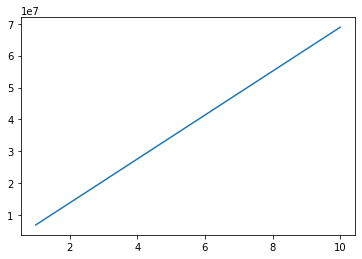

In [229]:
plt.plot(child_sche['year'], child_sche['Total annual positive economic impact'])